üìä Carregando dados para BOVA11.SA...
‚úÖ Dados carregados: 1823 observa√ß√µes
üéØ Executando backtest de 5 estrat√©gias...
   ‚Ä¢ Testando: Buy & Hold
   ‚Ä¢ Testando: MA Cross (10,30)
   ‚Ä¢ Testando: MA Cross (20,50)
   ‚Ä¢ Testando: RSI (14,30,70)
   ‚Ä¢ Testando: RSI (21,25,75)


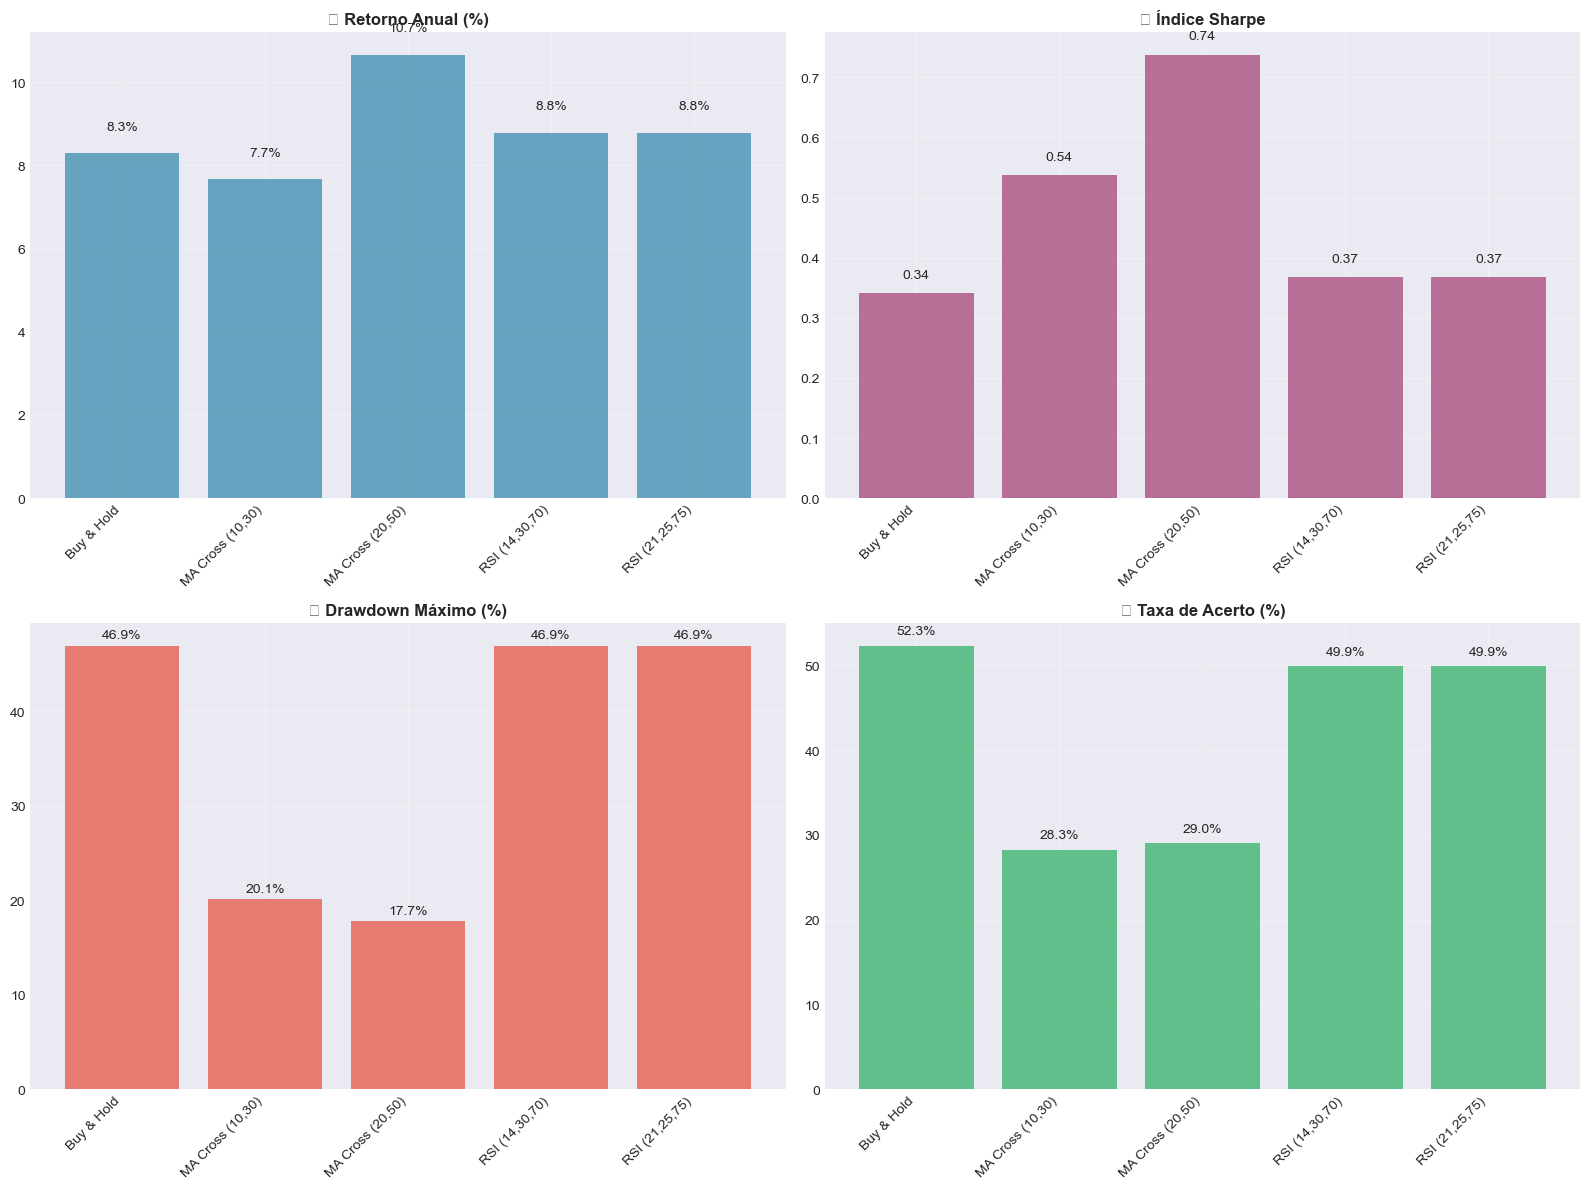

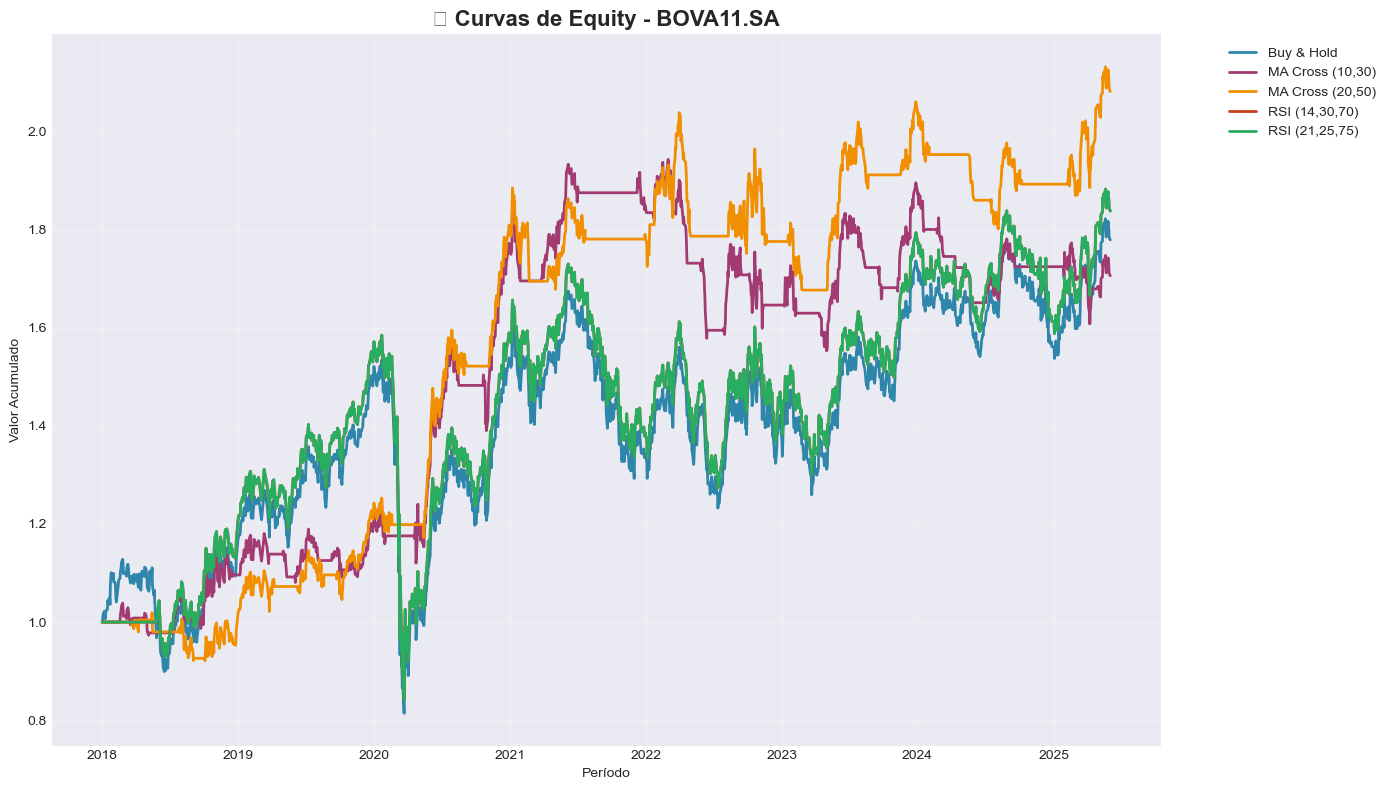

üìä RELAT√ìRIO DE ESTRAT√âGIAS - BOVA11.SA
üìÖ Per√≠odo: 2018-01-01 at√© 2025-06-03

üèÜ RANKING POR √çNDICE SHARPE:
--------------------------------------------------------------------------------
Posi√ß√£o  Estrat√©gia                Retorno      Sharpe     DD Max       Trades    
--------------------------------------------------------------------------------
1        MA Cross (20,50)             10.66%     0.74    17.74%       18
2        MA Cross (10,30)              7.66%     0.54    20.07%       32
3        RSI (14,30,70)                8.78%     0.37    46.93%        0
4        RSI (21,25,75)                8.78%     0.37    46.93%        0
5        Buy & Hold                    8.29%     0.34    46.93%        0

ü•á MELHOR ESTRAT√âGIA: MA Cross (20,50)
   ‚Ä¢ Retorno anual: 10.66%
   ‚Ä¢ Volatilidade: 14.45%
   ‚Ä¢ √çndice Sharpe: 0.74
   ‚Ä¢ Drawdown m√°ximo: 17.74%
   ‚Ä¢ Taxa de acerto: 29.02%

üéØ Executando Monte Carlo na melhor estrat√©gia: MA Cross (20,50)
üé≤ Mon

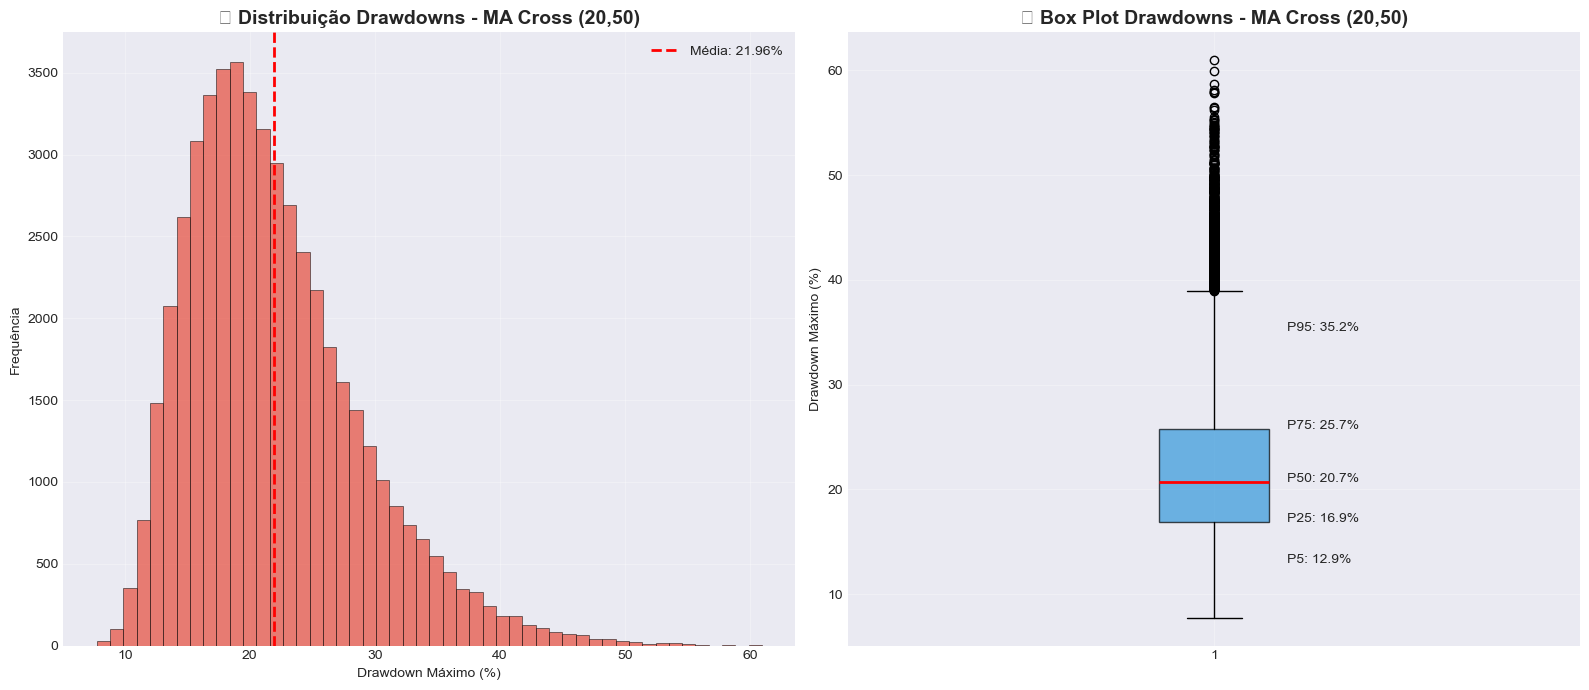


üéØ AN√ÅLISE DE RISCO MONTE CARLO - MA Cross (20,50)
üìä Estat√≠sticas dos Drawdowns (3 anos, 50k simula√ß√µes):
   ‚Ä¢ Drawdown m√©dio: 21.96%
   ‚Ä¢ Drawdown mediano: 20.74%
   ‚Ä¢ Desvio padr√£o: 6.93%
   ‚Ä¢ M√≠nimo: 7.75%
   ‚Ä¢ M√°ximo: 60.96%

üéØ Cen√°rios de Risco (Prob. de EXCEDER):
   ‚Ä¢ 50% chance: DD > 20.74%
   ‚Ä¢ 25% chance: DD > 25.72%
   ‚Ä¢ 10% chance: DD > 31.38%
   ‚Ä¢  5% chance: DD > 35.15%
   ‚Ä¢  1% chance: DD > 43.06%

‚ö†Ô∏è  Classifica√ß√£o de Risco: üü° M√âDIO

üîÑ AN√ÅLISE COMPARATIVA MULTI-ATIVOS

üìä Analisando PETR4.SA...
üìä Carregando dados para PETR4.SA...
‚úÖ Dados carregados: 1347 observa√ß√µes
üéØ Executando backtest de 5 estrat√©gias...
   ‚Ä¢ Testando: Buy & Hold
   ‚Ä¢ Testando: MA Cross (10,30)
   ‚Ä¢ Testando: MA Cross (20,50)
   ‚Ä¢ Testando: RSI (14,30,70)
   ‚Ä¢ Testando: RSI (21,25,75)
   üèÜ Melhor: RSI (21,25,75) (Sharpe: 0.98)

üìä Analisando VALE3.SA...
üìä Carregando dados para VALE3.SA...
‚úÖ Dados carregados: 1347 obse

In [5]:
"""
Sistema Completo de Trading com An√°lise Monte Carlo de Drawdown
Implementa m√∫ltiplas estrat√©gias e avalia performance com simula√ß√µes
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from typing import Tuple, Dict, Optional, List
import time
from abc import ABC, abstractmethod

class TradingStrategy(ABC):
    """Classe base abstrata para estrat√©gias de trading"""
    
    def __init__(self, name: str):
        self.name = name
        self.signals = None
        self.positions = None
        self.returns = None
    
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais de compra/venda baseado nos dados"""
        pass
    
    def backtest(self, data: pd.DataFrame) -> Dict:
        """Executa backtest da estrat√©gia"""
        # Gera sinais
        self.signals = self.generate_signals(data)
        
        # Calcula posi√ß√µes (1 = comprado, 0 = fora, -1 = vendido)
        self.positions = self.signals.shift(1).fillna(0)
        
        # Calcula retornos da estrat√©gia
        market_returns = data['Adj Close'].pct_change()
        self.returns = self.positions * market_returns
        
        # Calcula m√©tricas
        total_return = (1 + self.returns).prod() - 1
        annual_return = (1 + total_return) ** (252 / len(self.returns)) - 1
        volatility = self.returns.std() * np.sqrt(252)
        sharpe = annual_return / volatility if volatility > 0 else 0
        
        # Calcula drawdown
        cumulative = (1 + self.returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'win_rate': (self.returns > 0).mean(),
            'total_trades': abs(self.signals.diff()).sum() / 2
        }

class MovingAverageCrossStrategy(TradingStrategy):
    """Estrat√©gia de cruzamento de m√©dias m√≥veis"""
    
    def __init__(self, short_window: int = 20, long_window: int = 50):
        super().__init__(f"MA Cross ({short_window},{long_window})")
        self.short_window = short_window
        self.long_window = long_window
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais baseados no cruzamento de m√©dias m√≥veis"""
        short_ma = data['Adj Close'].rolling(window=self.short_window).mean()
        long_ma = data['Adj Close'].rolling(window=self.long_window).mean()
        
        signals = pd.Series(0, index=data.index)
        signals[short_ma > long_ma] = 1  # Compra quando MA curta > MA longa
        signals[short_ma < long_ma] = 0  # Vende quando MA curta < MA longa
        
        return signals

class RSIStrategy(TradingStrategy):
    """Estrat√©gia baseada no RSI (Relative Strength Index)"""
    
    def __init__(self, rsi_period: int = 14, oversold: float = 30, overbought: float = 70):
        super().__init__(f"RSI ({rsi_period},{oversold},{overbought})")
        self.rsi_period = rsi_period
        self.oversold = oversold
        self.overbought = overbought
    
    def calculate_rsi(self, prices: pd.Series) -> pd.Series:
        """Calcula o RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais baseados no RSI"""
        rsi = self.calculate_rsi(data['Adj Close'])
        
        signals = pd.Series(0, index=data.index)
        signals[rsi < self.oversold] = 1   # Compra quando oversold
        signals[rsi > self.overbought] = 0  # Vende quando overbought
        
        # Mant√©m posi√ß√£o entre sinais
        signals = signals.replace(0, np.nan).fillna(method='ffill').fillna(0)
        
        return signals



class BuyAndHoldStrategy(TradingStrategy):
    """Estrat√©gia Buy and Hold (benchmark)"""
    
    def __init__(self):
        super().__init__("Buy & Hold")
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Sempre mant√©m posi√ß√£o comprada"""
        return pd.Series(1, index=data.index)

class AdvancedTradingAnalyzer:
    """Analisador avan√ßado de estrat√©gias com Monte Carlo"""
    
    def __init__(self, ticker: str, start_date: str = "2015-01-01", 
                 end_date: Optional[str] = None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date or datetime.today().strftime("%Y-%m-%d")
        self.data = None
        self.strategies = []
        self.results = {}
        
    def load_data(self) -> pd.DataFrame:
        """Carrega dados hist√≥ricos"""
        print(f"üìä Carregando dados para {self.ticker}...")
        
        try:
            self.data = yf.download(self.ticker, self.start_date, self.end_date, 
                                  auto_adjust=False, progress=False)
            
            if self.data.empty:
                raise ValueError(f"Nenhum dado encontrado para {self.ticker}")
            
            if isinstance(self.data.columns, pd.MultiIndex):
                self.data.columns = self.data.columns.get_level_values(0)
            
            print(f"‚úÖ Dados carregados: {len(self.data)} observa√ß√µes")
            return self.data
            
        except Exception as e:
            print(f"‚ùå Erro ao carregar dados: {e}")
            raise
    
    def add_strategies(self):
        """Adiciona todas as estrat√©gias dispon√≠veis"""
        self.strategies = [
            BuyAndHoldStrategy(),
            MovingAverageCrossStrategy(10, 30),
            MovingAverageCrossStrategy(20, 50),
            RSIStrategy(14, 30, 70),
            RSIStrategy(21, 25, 75)
        ]
    
    def backtest_strategies(self) -> Dict:
        """Executa backtest de todas as estrat√©gias"""
        if self.data is None:
            self.load_data()
        
        print(f"üéØ Executando backtest de {len(self.strategies)} estrat√©gias...")
        
        for strategy in self.strategies:
            print(f"   ‚Ä¢ Testando: {strategy.name}")
            self.results[strategy.name] = strategy.backtest(self.data)
            self.results[strategy.name]['strategy'] = strategy
        
        return self.results
    
    def plot_strategy_comparison(self):
        """Plota compara√ß√£o de performance das estrat√©gias"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # M√©tricas para compara√ß√£o
        strategies = list(self.results.keys())
        returns = [self.results[s]['annual_return'] * 100 for s in strategies]
        sharpe_ratios = [self.results[s]['sharpe_ratio'] for s in strategies]
        max_drawdowns = [abs(self.results[s]['max_drawdown']) * 100 for s in strategies]
        win_rates = [self.results[s]['win_rate'] * 100 for s in strategies]
        
        # Gr√°fico 1: Retorno Anual
        bars1 = ax1.bar(range(len(strategies)), returns, color='#2E86AB', alpha=0.7)
        ax1.set_title('üìà Retorno Anual (%)', fontweight='bold')
        ax1.set_xticks(range(len(strategies)))
        ax1.set_xticklabels(strategies, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        # Adiciona valores nas barras
        for bar, value in zip(bars1, returns):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        # Gr√°fico 2: Sharpe Ratio
        bars2 = ax2.bar(range(len(strategies)), sharpe_ratios, color='#A23B72', alpha=0.7)
        ax2.set_title('‚ö° √çndice Sharpe', fontweight='bold')
        ax2.set_xticks(range(len(strategies)))
        ax2.set_xticklabels(strategies, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        for bar, value in zip(bars2, sharpe_ratios):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.2f}', ha='center', va='bottom')
        
        # Gr√°fico 3: Maximum Drawdown
        bars3 = ax3.bar(range(len(strategies)), max_drawdowns, color='#E74C3C', alpha=0.7)
        ax3.set_title('üìâ Drawdown M√°ximo (%)', fontweight='bold')
        ax3.set_xticks(range(len(strategies)))
        ax3.set_xticklabels(strategies, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars3, max_drawdowns):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        # Gr√°fico 4: Win Rate
        bars4 = ax4.bar(range(len(strategies)), win_rates, color='#27AE60', alpha=0.7)
        ax4.set_title('üéØ Taxa de Acerto (%)', fontweight='bold')
        ax4.set_xticks(range(len(strategies)))
        ax4.set_xticklabels(strategies, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
        
        for bar, value in zip(bars4, win_rates):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def plot_equity_curves(self):
        """Plota curvas de equity das estrat√©gias"""
        plt.figure(figsize=(14, 8))
        
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#27AE60', '#8E44AD', '#E67E22']
        
        for i, (name, result) in enumerate(self.results.items()):
            strategy = result['strategy']
            if strategy.returns is not None:
                equity_curve = (1 + strategy.returns.fillna(0)).cumprod()
                plt.plot(equity_curve.index, equity_curve.values, 
                        label=name, linewidth=2, color=colors[i % len(colors)])
        
        plt.title(f'üìä Curvas de Equity - {self.ticker}', fontsize=16, fontweight='bold')
        plt.xlabel('Per√≠odo')
        plt.ylabel('Valor Acumulado')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def run_monte_carlo_on_strategy(self, strategy_name: str, years: int = 3, 
                                   num_simulations: int = 50000) -> np.ndarray:
        """Executa Monte Carlo espec√≠fico para uma estrat√©gia"""
        if strategy_name not in self.results:
            raise ValueError(f"Estrat√©gia '{strategy_name}' n√£o encontrada")
        
        strategy = self.results[strategy_name]['strategy']
        if strategy.returns is None:
            raise ValueError("Estrat√©gia n√£o foi executada ainda")
        
        # Remove valores NaN e zeros
        clean_returns = strategy.returns.dropna()
        clean_returns = clean_returns[clean_returns != 0]
        
        if len(clean_returns) < 50:
            print(f"‚ö†Ô∏è  Poucos retornos v√°lidos para {strategy_name} ({len(clean_returns)})")
            return np.array([])
        
        print(f"üé≤ Monte Carlo para estrat√©gia: {strategy_name}")
        print(f"   ‚Ä¢ Retornos hist√≥ricos: {len(clean_returns)}")
        
        num_days = years * 252
        drawdowns = np.zeros(num_simulations)
        
        # Pre√ßo inicial (√∫ltimo pre√ßo conhecido)
        initial_value = 100000  # Valor inicial de R$ 100.000
        
        for i in range(num_simulations):
            # Simula retornos futuros
            sim_returns = np.random.choice(clean_returns.values, size=num_days, replace=True)
            
            # Calcula valores da carteira
            portfolio_values = initial_value * np.cumprod(1 + sim_returns)
            
            # Calcula drawdown
            running_max = np.maximum.accumulate(portfolio_values)
            drawdown_series = (running_max - portfolio_values) / running_max
            max_drawdown = np.max(drawdown_series)
            
            drawdowns[i] = max_drawdown
        
        return drawdowns
    
    def generate_strategy_report(self):
        """Gera relat√≥rio completo das estrat√©gias"""
        print("=" * 80)
        print(f"üìä RELAT√ìRIO DE ESTRAT√âGIAS - {self.ticker}")
        print("=" * 80)
        print(f"üìÖ Per√≠odo: {self.start_date} at√© {self.end_date}")
        print()
        
        # Ordena estrat√©gias por Sharpe Ratio
        sorted_strategies = sorted(self.results.items(), 
                                 key=lambda x: x[1]['sharpe_ratio'], reverse=True)
        
        print("üèÜ RANKING POR √çNDICE SHARPE:")
        print("-" * 80)
        print(f"{'Posi√ß√£o':<8} {'Estrat√©gia':<25} {'Retorno':<12} {'Sharpe':<10} {'DD Max':<12} {'Trades':<10}")
        print("-" * 80)
        
        for i, (name, result) in enumerate(sorted_strategies, 1):
            print(f"{i:<8} {name:<25} {result['annual_return']*100:>8.2f}% "
                  f"{result['sharpe_ratio']:>8.2f} {abs(result['max_drawdown'])*100:>8.2f}% "
                  f"{result['total_trades']:>8.0f}")
        
        print("=" * 80)
        
        # An√°lise da melhor estrat√©gia
        best_strategy = sorted_strategies[0]
        print(f"\nü•á MELHOR ESTRAT√âGIA: {best_strategy[0]}")
        print(f"   ‚Ä¢ Retorno anual: {best_strategy[1]['annual_return']*100:.2f}%")
        print(f"   ‚Ä¢ Volatilidade: {best_strategy[1]['volatility']*100:.2f}%")
        print(f"   ‚Ä¢ √çndice Sharpe: {best_strategy[1]['sharpe_ratio']:.2f}")
        print(f"   ‚Ä¢ Drawdown m√°ximo: {abs(best_strategy[1]['max_drawdown'])*100:.2f}%")
        print(f"   ‚Ä¢ Taxa de acerto: {best_strategy[1]['win_rate']*100:.2f}%")
        
        return best_strategy[0]
    
    def run_complete_analysis(self):
        """Executa an√°lise completa com todas as estrat√©gias"""
        # Carrega dados e configura estrat√©gias
        self.load_data()
        self.add_strategies()
        
        # Executa backtests
        self.backtest_strategies()
        
        # Plota compara√ß√µes
        self.plot_strategy_comparison()
        self.plot_equity_curves()
        
        # Gera relat√≥rio
        best_strategy = self.generate_strategy_report()
        
        # Monte Carlo na melhor estrat√©gia
        print(f"\nüéØ Executando Monte Carlo na melhor estrat√©gia: {best_strategy}")
        drawdowns = self.run_monte_carlo_on_strategy(best_strategy, years=3, num_simulations=50000)
        
        if len(drawdowns) > 0:
            self.plot_drawdown_analysis(drawdowns, best_strategy)
            self.generate_risk_report(drawdowns, best_strategy)
        
        return best_strategy, drawdowns
    
    def plot_drawdown_analysis(self, drawdowns: np.ndarray, strategy_name: str):
        """Plota an√°lise de drawdown para estrat√©gia espec√≠fica"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        dd_pct = drawdowns * 100
        
        # Histograma
        ax1.hist(dd_pct, bins=50, alpha=0.7, color='#E74C3C', 
                edgecolor='black', linewidth=0.5)
        ax1.set_title(f'üìä Distribui√ß√£o Drawdowns - {strategy_name}', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Drawdown M√°ximo (%)')
        ax1.set_ylabel('Frequ√™ncia')
        ax1.grid(True, alpha=0.3)
        
        # Adiciona linha da m√©dia
        mean_dd = np.mean(dd_pct)
        ax1.axvline(mean_dd, color='red', linestyle='--', linewidth=2, 
                   label=f'M√©dia: {mean_dd:.2f}%')
        ax1.legend()
        
        # Box plot com percentis
        bp = ax2.boxplot(dd_pct, vert=True, patch_artist=True,
                        boxprops=dict(facecolor='#3498DB', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
        
        ax2.set_title(f'üìà Box Plot Drawdowns - {strategy_name}', 
                     fontsize=14, fontweight='bold')
        ax2.set_ylabel('Drawdown M√°ximo (%)')
        ax2.grid(True, alpha=0.3)
        
        # Adiciona percentis ao lado
        percentiles = [5, 25, 50, 75, 95]
        values = np.percentile(dd_pct, percentiles)
        for p, v in zip(percentiles, values):
            ax2.text(1.1, v, f'P{p}: {v:.1f}%', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def generate_risk_report(self, drawdowns: np.ndarray, strategy_name: str):
        """Gera relat√≥rio de risco para estrat√©gia espec√≠fica"""
        dd_pct = drawdowns * 100
        
        print(f"\nüéØ AN√ÅLISE DE RISCO MONTE CARLO - {strategy_name}")
        print("=" * 60)
        print(f"üìä Estat√≠sticas dos Drawdowns (3 anos, 50k simula√ß√µes):")
        print(f"   ‚Ä¢ Drawdown m√©dio: {np.mean(dd_pct):.2f}%")
        print(f"   ‚Ä¢ Drawdown mediano: {np.median(dd_pct):.2f}%")
        print(f"   ‚Ä¢ Desvio padr√£o: {np.std(dd_pct):.2f}%")
        print(f"   ‚Ä¢ M√≠nimo: {np.min(dd_pct):.2f}%")
        print(f"   ‚Ä¢ M√°ximo: {np.max(dd_pct):.2f}%")
        
        print(f"\nüéØ Cen√°rios de Risco (Prob. de EXCEDER):")
        probs = [50, 25, 10, 5, 1]
        percentiles = [50, 75, 90, 95, 99]
        
        for prob, perc in zip(probs, percentiles):
            value = np.percentile(dd_pct, perc)
            print(f"   ‚Ä¢ {prob:2d}% chance: DD > {value:.2f}%")
        
        # Classifica√ß√£o de risco
        median_dd = np.median(dd_pct)
        if median_dd < 15:
            risk_class = "üü¢ BAIXO"
        elif median_dd < 25:
            risk_class = "üü° M√âDIO"
        else:
            risk_class = "üî¥ ALTO"
        
        print(f"\n‚ö†Ô∏è  Classifica√ß√£o de Risco: {risk_class}")
        print("=" * 60)

# Exemplo de uso
if __name__ == "__main__":
    # An√°lise completa
    analyzer = AdvancedTradingAnalyzer("BOVA11.SA", start_date="2018-01-01")
    best_strategy, drawdowns = analyzer.run_complete_analysis()
    
    # An√°lise adicional para outros ativos
    print("\n" + "="*80)
    print("üîÑ AN√ÅLISE COMPARATIVA MULTI-ATIVOS")
    print("="*80)
    
    tickers = ["PETR4.SA", "VALE3.SA", "BBAS3.SA"]
    
    for ticker in tickers:
        try:
            print(f"\nüìä Analisando {ticker}...")
            quick_analyzer = AdvancedTradingAnalyzer(ticker, start_date="2020-01-01")
            quick_analyzer.load_data()
            quick_analyzer.add_strategies()
            quick_analyzer.backtest_strategies()
            
            # Encontra melhor estrat√©gia
            best = max(quick_analyzer.results.items(), 
                      key=lambda x: x[1]['sharpe_ratio'])
            
            print(f"   üèÜ Melhor: {best[0]} (Sharpe: {best[1]['sharpe_ratio']:.2f})")
            
        except Exception as e:
            print(f"   ‚ùå Erro em {ticker}: {e}")

In [ ]:
# Carregando as bibliotecas

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


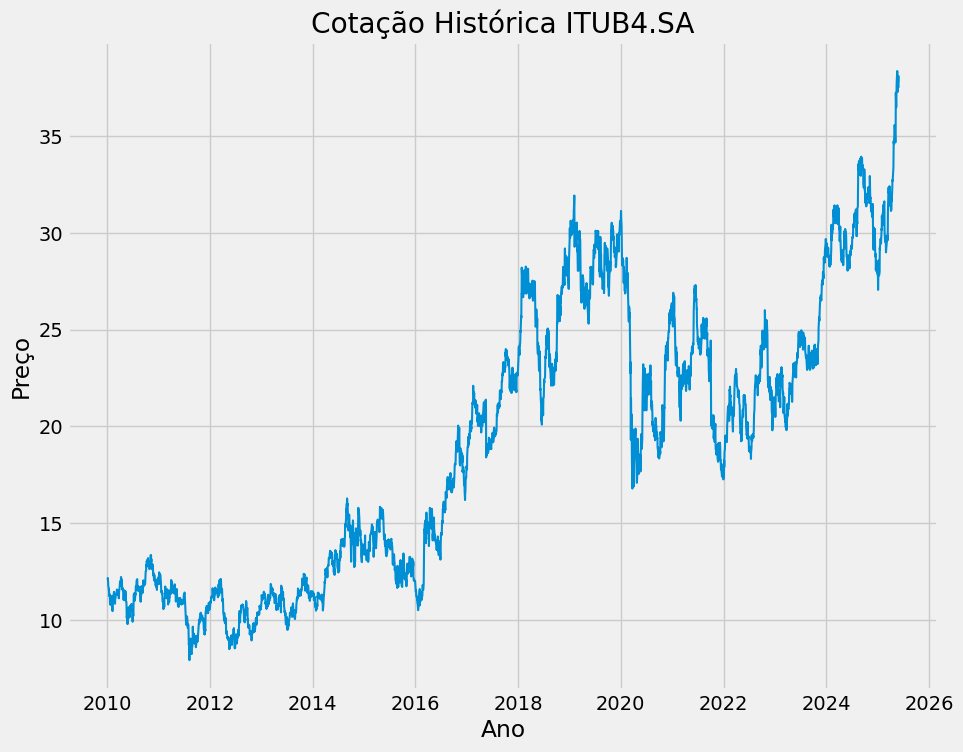

In [14]:
# Carregando a base de dados e fazendo os checks iniciais

plt.style.use("fivethirtyeight")

# Carrega a base
ticker = "ITUB4.SA"
inicio = "2010-01-01"
fim = datetime.today().strftime("%Y-%m-%d")
df1 = yf.download(ticker, inicio, fim, auto_adjust=False)
df1.columns=df1.columns.get_level_values(0)

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(df1["Adj Close"], linewidth = 1.5)
    plt.xlabel("Ano")
    plt.ylabel("Pre√ßo")
    plt.title("Cota√ß√£o Hist√≥rica " + ticker)
    plt.show();

In [15]:
# Calculando os retornos di√°rios, dentro e fora do dataframe

df1["Retorno"] = df1["Adj Close"].pct_change(1)

retornos = df1["Adj Close"].pct_change(1).dropna().to_numpy()

In [16]:
retornos

array([ 0.00648101, -0.00866747, -0.01024318, ...,  0.00793649,
       -0.00813642, -0.00793859])

In [17]:
# Vamos considerar 3 anos para frente e que 1 ano tenha 252 dias √∫teis 

anos = 3
num_dias = anos * 252
ultimo_preco = float(df1["Adj Close"].tail(1))

In [18]:
ultimo_preco

37.4900016784668

In [19]:
# E vamos calcular o drawdown m√°ximo

# Simula os retornos di√°rios dos pr√≥ximos 3 anos
sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

# Faz o c√°lculo do valor da carteira com retorno composto
sim_val = ultimo_preco*(1 + sim_ret).cumprod()

# Calcula o valor m√°ximo da carteira simulada
max_val = np.maximum.accumulate(sim_val)

# Encontra o drawdown m√°ximo
max_dd = np.max((max_val - sim_val)/max_val)

max_dd

0.5364704580415984

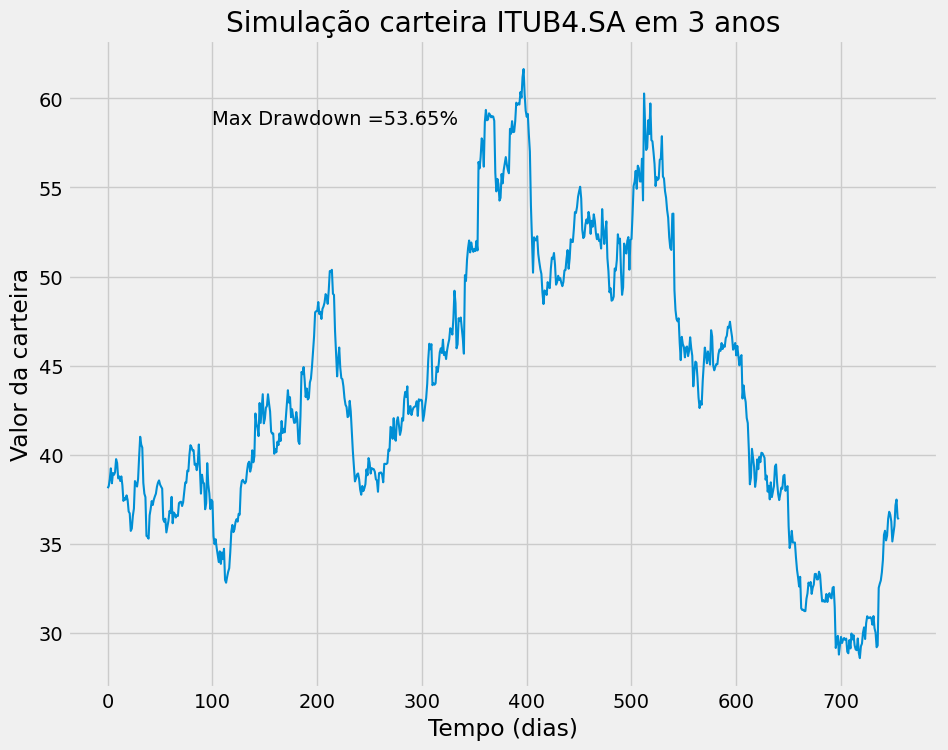

In [20]:
# Visualiza√ß√£o da simula√ß√£o do valor da carteira

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(sim_val, linewidth = 1.5)
    plt.xlabel("Tempo (dias)")
    plt.ylabel("Valor da carteira")
    plt.annotate("Max Drawdown =" + str(round(max_dd*100, 2)) + "%", (100, np.max(sim_val)*0.95))
    plt.title("Simula√ß√£o carteira " + ticker + " em " + str(anos) + " anos")
    plt.show();

In [21]:
# Vamos ao Monte Carlo com X simula√ß√µes 

num_sim = 100000

dd = np.array([])

for n in range(num_sim): # basta colocar a l√≥gica anterior dentro de um la√ßo for
    # Simula os retornos di√°rios dos pr√≥ximos 3 anos
    sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

    # Faz o c√°lculo do valor da carteira com retorno composto
    sim_val = ultimo_preco*(1 + sim_ret).cumprod()

    # Calcula o valor m√°ximo da carteira simulada
    max_val = np.maximum.accumulate(sim_val)

    # Encontra o drawdown m√°ximo
    max_dd = np.max((max_val - sim_val)/max_val)
    dd = np.append(dd, max_dd)

In [22]:
dd

array([0.33097164, 0.69237624, 0.39236653, ..., 0.5395264 , 0.49923558,
       0.35332245])

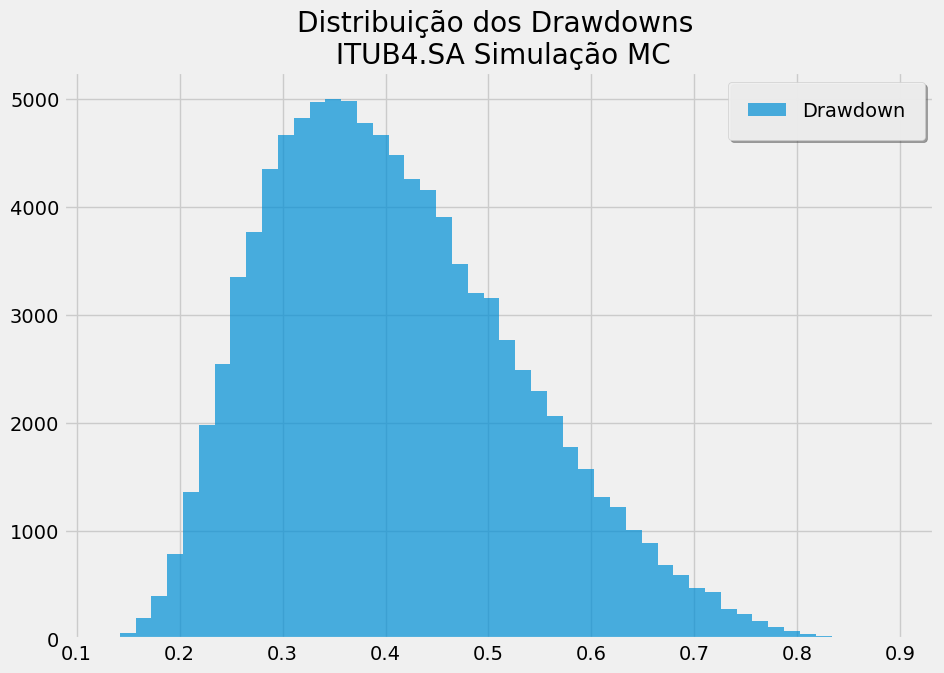

In [23]:
# Vamos visualizar a distribui√ß√£o dos drawdowns

config = dict(histtype = "stepfilled", alpha = 0.7, density = False, bins = 50)

plt.figure(figsize = (10,7))
plt.hist(dd, **config, label = "Drawdown")

# Formata√ßao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Distribui√ß√£o dos Drawdowns \n " + ticker + " Simula√ß√£o MC")
plt.show();

In [24]:
# Por fim, as estat√≠sticas importantes

print("Para o ativo " + ticker + " segundo uma simula√ß√£o de Monte Carlo,")
print("com " + str(num_sim) + " simula√ß√µes, em " + str(anos) + " anos podemos esperar:")
print()
print("---------------------------------------------------------")
print("Drawdown m√©dio " + str(round(np.mean(dd*100), 2)) + "%")
print()
print("Com: ")
print("    50% de probabilidade, o DD ser√° maior do que " + str(round(np.median(dd*100), 2)) + "%")
print("    25% de probabilidade, o DD ser√° maior do que " + str(round(np.percentile(dd*100, 75), 2)) + "%")
print("     5% de probabilidade, o DD ser√° maior do que " + str(round(np.percentile(dd*100, 95), 2)) + "%")
print("---------------------------------------------------------")
print()
print("Per√≠odo dos par√¢metros para a simula√ß√£o: " + inicio  + " √† " + fim)

Para o ativo ITUB4.SA segundo uma simula√ß√£o de Monte Carlo,
com 100000 simula√ß√µes, em 3 anos podemos esperar:

---------------------------------------------------------
Drawdown m√©dio 40.91%

Com: 
    50% de probabilidade, o DD ser√° maior do que 39.39%
    25% de probabilidade, o DD ser√° maior do que 48.9%
     5% de probabilidade, o DD ser√° maior do que 63.45%
---------------------------------------------------------

Per√≠odo dos par√¢metros para a simula√ß√£o: 2010-01-01 √† 2025-05-30


Quanto voce pode ter alocado em uma carteira e perder

O problema da simula√ß√£o de monte carlo √© que ela admite que os dados pertencem a uma distribui√ß√£o normal